In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import time as time
import xgboost as xgb
from pyearth import Earth

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
nan_cols = test.isna().sum()
test1 = test.drop(nan_cols[nan_cols > 269].index.tolist(), axis = 1)
train1 = train.drop(nan_cols[nan_cols > 269].index.tolist(), axis = 1)

In [4]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)

# fit and transform the data
test_imputed = pd.DataFrame(imputer.fit_transform(test1), columns=test1.columns)
train_imputed = pd.DataFrame(imputer.fit_transform(train1), columns=train1.columns)

In [5]:
corr_matrix = train_imputed.corr().abs()

corr_y = train_imputed.corrwith(train_imputed['y'])
train_imputed.drop(corr_y[corr_y.isna()].index.tolist(), axis = 1, inplace = True)
test_imputed.drop(corr_y[corr_y.isna()].index.tolist(), axis = 1, inplace = True)

# identify predictors that have correlation of >0.85
indices = np.where(np.triu(corr_matrix > 0.85, k=1))

# print the pairs of columns that have a correlation > 0.7
high_corr = []
count = 0
for idx in range(len(indices[0])):
    col1 = corr_matrix.columns[indices[0][idx]]
    col2 = corr_matrix.columns[indices[1][idx]]
    high_corr.append(col1)
    count+=1
    #print(f"{col1} and {col2}")
#print(count)

unique_vals = set(high_corr)
train_imputed = train_imputed.drop(unique_vals, axis = 1)

test_col = train_imputed.drop('y', axis = 1)
test_imputed = test_imputed[test_col.columns]

In [6]:
corr_y = train_imputed.corrwith(train_imputed['y'])
top_30 = corr_y.abs().sort_values(ascending = False)[1:31]

top_30.index

X = train_imputed[top_30.index.tolist()]
y = train_imputed.y
X_test = test_imputed[top_30.index.tolist()]


In [7]:
# Tuning lambda

alphas = 10**np.linspace(10,-2,100)*0.1

In [8]:
#Finding the lasso coefficients for increasing values of the tuning parameter
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X, y)
    coefs.append(lasso.coef_)

In [11]:
alphas = 10**np.linspace(-1,-5,200)*0.5
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000)
lassocv.fit(X, y)

#Optimal value of the tuning parameter - lamda
lassocv.alpha_

0.004505509125832509

In [17]:
lasso = Lasso(alpha = lassocv.alpha_)
lasso.fit(X, y) # RMSE 9.67!!

Lasso(alpha=0.004505509125832509)

In [18]:
pred = pd.DataFrame()
pred['id'] = test['id']
pred['y'] = lasso.predict(X_test)
pred = pred.set_index(['id'])
pred.to_csv('Witarsa_Ashley_regression.csv') 

### PCA

In [77]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)

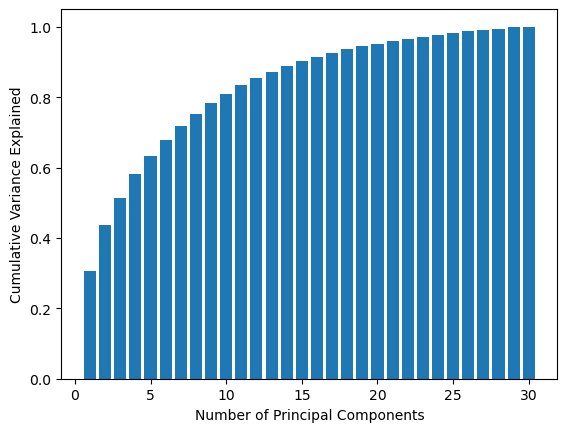

In [27]:
from sklearn.decomposition import PCA
plt.rcParams.update(plt.rcParamsDefault)
pca = PCA()
pca.fit(X_scaled)

# Get the explained variance ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate the cumulative sum of the explained variance ratios
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot the cumulative sum of the explained variance ratios against the number of principal components
plt.bar(range(1, pca.n_components_ + 1), cumulative_variance_ratio)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.show()

In [76]:
pca = PCA(n_components = 0.95)
pca.fit(X_scaled)

PCA(n_components=0.95)

In [78]:
X_train_pca = pca.transform(X_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [79]:
lasso.fit(X_train_pca, y)
pred = pd.DataFrame()
pred['id'] = test['id']
pred['y'] = lasso.predict(X_test_pca)
pred = pred.set_index(['id'])
pred.to_csv('Witarsa_Ashley_regression.csv') 

#### PCA of everything except corr > 0.85

In [53]:
dropped_cols = train_imputed.columns.difference(X.columns)
dropped_cols = dropped_cols.drop(['id', 'y'])

In [60]:
X_imputed = train_imputed.drop('y', axis = 1)

In [63]:
scaler = StandardScaler().fit(X_imputed)
X_imputed_scaled = scaler.transform(X_imputed)
X_test_scaled = scaler.transform(test_imputed)

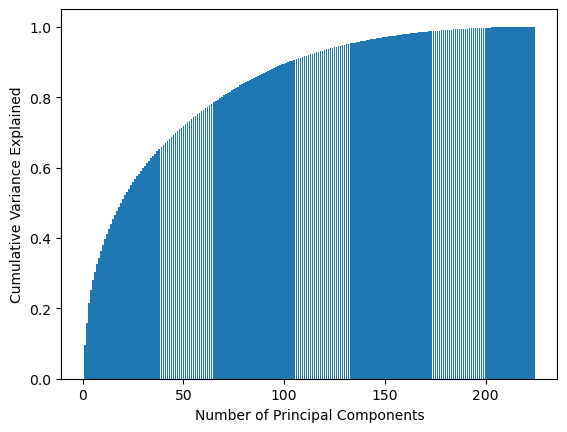

In [64]:
plt.rcParams.update(plt.rcParamsDefault)
pca = PCA()
pca.fit(X_imputed_scaled)

# Get the explained variance ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate the cumulative sum of the explained variance ratios
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot the cumulative sum of the explained variance ratios against the number of principal components
plt.bar(range(1, pca.n_components_ + 1), cumulative_variance_ratio)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.show()

In [70]:
pca = PCA(n_components = 0.95)
pca.fit(X_imputed_scaled)

PCA(n_components=0.95)

In [72]:
X_train_pca = pca.transform(X_imputed_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [73]:
lasso.fit(X_train_pca, y)
pred = pd.DataFrame()
pred['id'] = test['id']
pred['y'] = lasso.predict(X_test_pca)
pred = pred.set_index(['id'])
pred.to_csv('Witarsa_Ashley_regression.csv') 